In [2]:
!pip install -q bertopic
!pip install -q pymystem3
import numpy as np
import pandas as pd
from bertopic import BERTopic
import re
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

2024-07-31 19:08:15.755612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:08:15.755714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:08:15.890472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [86]:
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
corpus_dir = '/kaggle/input/glowbytedataset/Crime And Punishment.txt'

In [5]:
character_set = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}„“~—\"\-]–+«»…"
stopwords_ru = set(stopwords.words("russian")+ ["это", "твой","свой","всё", "который", "ещё"])

In [6]:
def is_match(regex, text):
    pattern = re.compile(regex)
    return pattern.search(text) is not None

In [7]:
with open(corpus_dir) as f:
    lines = f.readlines()

In [8]:
seq_sentences = []
for line in lines:
    if line == '\n':
        continue
    else:
        for l in line.split('\n'):
            if is_match('[\\*A-Za-z]',l):
                continue
            else:
                for seq in l.split('.'):
                    seq_sentences.append(seq)

In [9]:
mystem = Mystem()
def preprocess_text(text):
    text = re.sub('a-z*\w*\d\w*', '', text)
    text = text.replace('\n','')
    text = [c for c in text if c not in character_set]
    text = ''.join(text)
    
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words\
              and token != " " and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [10]:
df = pd.DataFrame(seq_sentences,columns=['text'])
df['clean_text'] = df['text'].apply(preprocess_text)
df = df.drop(df[df['clean_text'].str.len() <= 2].index).reset_index(drop=True)

## Embedding visualization 

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [16]:
sentences = df['text'].to_list()

In [17]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [27]:
model = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model.to(device)
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

In [36]:
# torch.cuda.empty_cache()
# import gc
# gc.collect()

0

In [68]:
model_output = []
model.eval()
with torch.no_grad():
    for ids,mask,token_type in zip(encoded_input['input_ids'],encoded_input['attention_mask'],encoded_input['token_type_ids']):
        ids = ids.to(device).unsqueeze(dim=0)
        token_type = token_type.to(device).unsqueeze(dim=0)
        mask = mask.to(device).unsqueeze(dim=0)
        out = model(ids,mask,token_type)
        model_output.append(mean_pooling(out,mask))
model_output = torch.cat(model_output)

In [74]:
model_output = model_output.cpu().numpy()


In [79]:
svd = TruncatedSVD(n_components = 50,n_iter = 10,random_state = 42)
model_output = svd.fit_transform(model_output)

In [81]:
from sklearn.manifold import TSNE
from sklearn.cluster import Birch
from sklearn.decomposition import TruncatedSVD

In [94]:
cluster = Birch(n_clusters = 10)
clustered_data =  cluster.fit_predict(model_output)
tsne = TSNE(n_components = 3)
emb = tsne.fit_transform(model_output,clustered_data)

In [98]:
def plot_embeddings(text_corpus):
    '''3д визуализация векторизации предложений'''
    fig = plt.figure(figsize = [10,10])
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(text_corpus[:,0],text_corpus[:,1],text_corpus[:,2],c = clustered_data,label = clustered_data)
    plt.show()

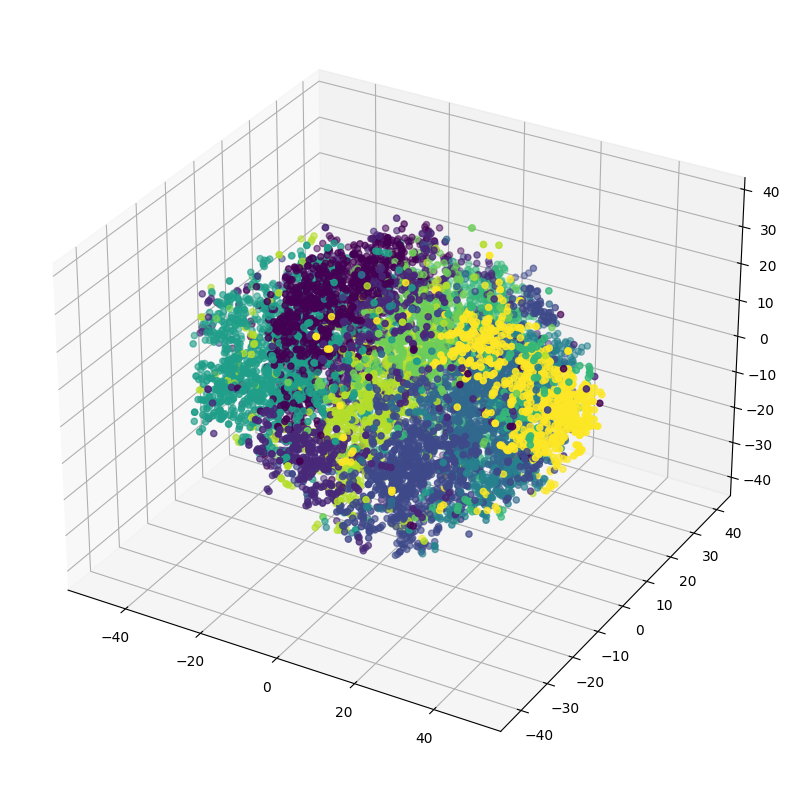

In [99]:
plot_embeddings(emb)

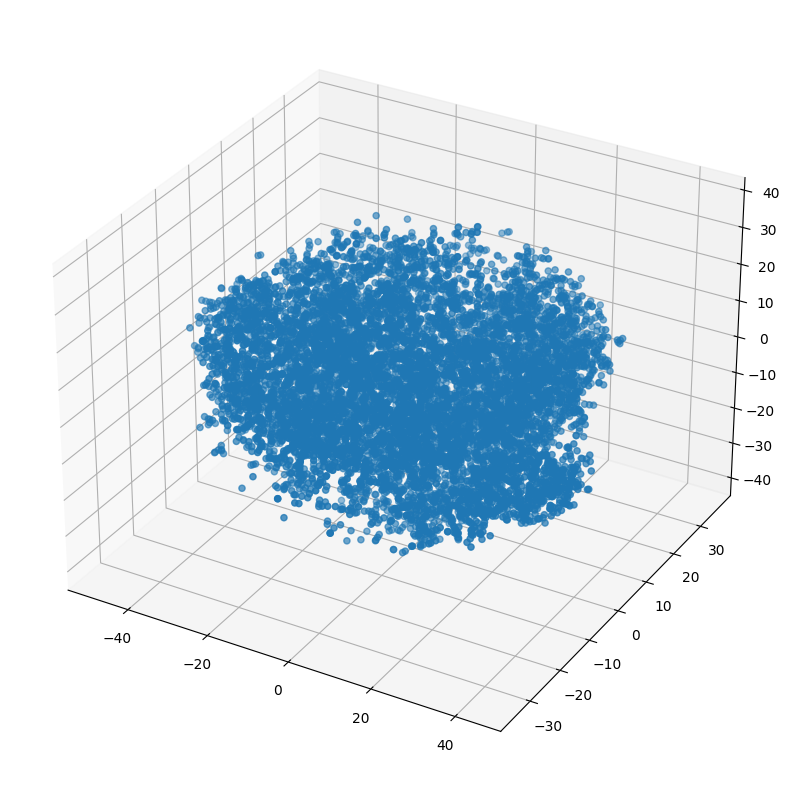

In [87]:
plot_embeddings(emb)

# Starter topics

In [ ]:
topic_model = BERTopic(language='multilingual', calculate_probabilities=True,verbose=False,min_topic_size = 15,n_gram_range = (1,3))
topics,probs = topic_model.fit_transform(df['clean_text'])

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=6)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=30)

In [25]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

### Using SberBert model for embeddings

In [26]:
embedding_model = SentenceTransformer("ai-forever/sbert_large_mt_nlu_ru")
#embedding_model = SentenceTransformer('ai-forever/ru-scibench-oecd-clustering-p2p')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [27]:
topic_model = BERTopic(embedding_model = embedding_model, calculate_probabilities=True,verbose=False,min_topic_size = 15,n_gram_range = (1,3))
topics,probs = topic_model.fit_transform(df['clean_text'])

In [28]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4398,-1_это_весь_мочь_свой,"[это, весь, мочь, свой, знать, человек, говори...","[порфирий, дело инстинкт начинать проникать ле..."
1,0,938,0_это_весь_мочь_свой,"[это, весь, мочь, свой, человек, лицо, станови...",[убеждение выходить это затмение рассудок упад...
2,1,539,1_раскольников_раскольник_раскольников расколь...,"[раскольников, раскольник, раскольников раскол...","[отвечать раскольников, отвечать раскольников,..."
3,2,401,2_дверь_комната_лестница_этаж,"[дверь, комната, лестница, этаж, квартира, вхо...",[дверь справа самый дверь который отделять ква...
4,3,251,3_деньги_рубль_пять_вещь,"[деньги, рубль, пять, вещь, двадцать, взять, т...","[деньги двадцать пять рубль, деньги, вопервых ..."
...,...,...,...,...,...
63,62,16,62_ивановна_петр петрович_петр_амалия ивановна,"[ивановна, петр петрович, петр, амалия ивановн...",[б пожалеть милостивый государь милостивый гос...
64,63,16,63_презрение_удовольствие_романовна_авдотья ро...,"[презрение, удовольствие, романовна, авдотья р...",[остальной бывший распивочная исключать хозяин...
65,64,16,64_спать_спать спать_спать вскричать_час шесть,"[спать, спать спать, спать вскричать, час шест...",[ах боже верить весь ночь спать вскричать бедн...
66,65,16,65_разумихин_крикнуть разумихин_крикнуть_крикн...,"[разумихин, крикнуть разумихин, крикнуть, крик...",[это пусть всетака вытаскивать крикнуть разуми...


In [64]:
representation_model = KeyBERTInspired()

In [65]:
topic_model = BERTopic(embedding_model = embedding_model,
                       calculate_probabilities=True,
                       verbose=False,
                       min_topic_size = 15,
                       n_gram_range = (1,3),
                       representation_model=representation_model)
topics,probs = topic_model.fit_transform(df['clean_text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4716,-1_это_свой_который_самый,"[это, свой, который, самый, первый, мочь, ваш,...",[твердо твердо укрепляться немой мысль действи...
1,0,924,0_мысль_случай_конец_преступление,"[мысль, случай, конец, преступление, свидригай...",[доходить вывод решать лично дело мочь подобны...
2,1,539,1_отвечать раскольников_отвечать раскольник_вс...,"[отвечать раскольников, отвечать раскольник, в...","[отвечать раскольников, отвечать раскольников,..."
3,2,335,2_отворять дверь_дверь_запирать дверь_запирать...,"[отворять дверь, дверь, запирать дверь, запира...",[стоять смотреть верить глаз свой дверь наружн...
4,3,243,3_рубль пятьдесят_двадцать рубль_рубль двадцат...,"[рубль пятьдесят, двадцать рубль, рубль двадца...","[деньги двадцать пять рубль, вопервых рубашка ..."
...,...,...,...,...,...
60,59,17,59_рассказывать кстати замет_рассказывать весь...,"[рассказывать кстати замет, рассказывать весь,...",[счет мочь рассказывать прелюбопытный эпизод к...
61,60,17,60_свидригайлов застреливаться вскричать_свидр...,"[свидригайлов застреливаться вскричать, свидри...","[сечь сечь становиться кричать голос толпа, ка..."
62,61,17,61_завтра прийти время_завтра час_завтра час с...,"[завтра прийти время, завтра час, завтра час с...","[завтра, приходитетко завтра час семомс, завтр..."
63,62,16,62_обстоятельство злоба относиться_малодушие б...,"[обстоятельство злоба относиться, малодушие бо...",[неужели малодушие боязнь смерть мочь заставля...


In [67]:
topic_model.visualize_barchart(top_n_topics=6)

По умолчанию BertTopic исползует HDBSCAN,который в свою очередь использует евклидово расстояние, как метрику расстояния

In [30]:
topic_model.visualize_topics()

In [1]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# def create_wordcloud(model, topic):
#     text = {word: value for word, value in model.get_topic(topic)}
#     wc = WordCloud(background_color="white", max_words=1000)
#     wc.generate_from_frequencies(text)
#     plt.imshow(wc, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

# # Show wordcloud
# create_wordcloud(topic_model, topic=1)

NameError: name 'topic_model' is not defined

### Different clustering algorithms and distance metrics

In [38]:
bscan_model = HDBSCAN(min_cluster_size=15, metric='manhattan', cluster_selection_method='eom', prediction_data=True)

In [39]:
topic_model = BERTopic(
    embedding_model = embedding_model, 
    calculate_probabilities=True,
    verbose=False,
    hdbscan_model = bscan_model,
    n_gram_range = (1,3),
)


In [41]:
topics,probs = topic_model.fit_transform(df['clean_text'])

In [42]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5008,-1_это_весь_мочь_свой,"[это, весь, мочь, свой, знать, становиться, че...",[дело инстинкт начинать проникать лебезятник п...
1,0,536,0_раскольников_раскольник_раскольников расколь...,"[раскольников, раскольник, раскольников раскол...","[отвечать раскольников, отвечать раскольников,..."
2,1,351,1_дверь_лестница_комната_этаж,"[дверь, лестница, комната, этаж, квартира, отв...",[дверь справа самый дверь который отделять ква...
3,2,269,2_деньги_рубль_тысяча_пять,"[деньги, рубль, тысяча, пять, взять, вещь, два...","[взять деньги вещь, деньги, вопервых рубашка х..."
4,3,192,3_пойти_контора_полиция_шулер,"[пойти, контора, полиция, шулер, игрок, такса,...","[пойти, пойти, пойти]"
...,...,...,...,...,...
68,67,17,67_завтра_сегодня_вчера_вчера вечер,"[завтра, сегодня, вчера, вчера вечер, вчерашни...","[снеситек завтра прийти время, приходитетко за..."
69,68,17,68_час_час час_час этак_одиннадцатый,"[час, час час, час этак, одиннадцатый, этак, з...","[час этак одиннадцать наверно, зайти ко сюда ч..."
70,69,16,69_постоять_настасья постоять_стоять_сидеть,"[постоять, настасья постоять, стоять, сидеть, ...","[постоять постой чудак, настасья постоять, пос..."
71,70,16,70_рассказывать_рассказывать рассказывать_долг...,"[рассказывать, рассказывать рассказывать, долг...",[счет мочь рассказывать прелюбопытный эпизод к...


In [43]:
topic_model.visualize_barchart(top_n_topics=6)

In [44]:
topic_model.visualize_topics()

In [57]:
bscan_model = HDBSCAN(min_cluster_size=15, metric='l2', cluster_selection_method='eom', prediction_data=True)

In [58]:
topic_model = BERTopic(
    embedding_model = embedding_model, 
    calculate_probabilities=True,
    verbose=False,
    hdbscan_model = bscan_model,
    n_gram_range = (1,3),
)


In [59]:
topics,probs = topic_model.fit_transform(df['clean_text'])

In [60]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4767,-1_это_весь_мочь_свой,"[это, весь, мочь, свой, знать, человек, говори...","[это, это, это]"
1,0,533,0_раскольников_раскольник_раскольников расколь...,"[раскольников, раскольник, раскольников раскол...","[раскольников, раскольников, раскольников]"
2,1,387,1_дверь_лестница_комната_этаж,"[дверь, лестница, комната, этаж, квартира, сто...","[стоять дверь, лестница, дверь]"
3,2,263,2_деньги_рубль_вещь_пять,"[деньги, рубль, вещь, пять, тысяча, взять, кар...",[узнавать несколько месяц оставлять университе...
4,3,261,3_соня_соня соня_спать_сон,"[соня, соня соня, спать, сон, соня это, это, з...","[прошептать соня, соня, соня]"
...,...,...,...,...,...
70,69,16,69_мать_дуня_могилка_разлука,"[мать, дуня, могилка, разлука, брат, сестра, н...",[мать сестра любить отчего ненавидеть ненавиде...
71,70,16,70_ждать_ваш мамаша_подождать_сидеть,"[ждать, ваш мамаша, подождать, сидеть, оба, ча...",[тотчас смекать птичка лететь сетка свой очере...
72,71,16,71_свидригайлов_свидригайлов сидеть_свидригайл...,"[свидригайлов, свидригайлов сидеть, свидригайл...","[свидригайлов нетерпение ударять кулак стол, с..."
73,72,15,72_беспокоиться_беспокойство_беспокойный_преду...,"[беспокоиться, беспокойство, беспокойный, пред...","[беспокоиться знать болтун никто сказать, бесп..."


In [61]:
topic_model.visualize_barchart(top_n_topics=6)

In [62]:
topic_model.visualize_topics()